# **Topic Modeling**

## **Step 1: Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
import re, string, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load dataset
file_path = "/content/drive/MyDrive/NLP_lab5/cleaned_restaurant_review_lemmas.csv"
df = pd.read_csv(file_path)

print("Data loaded. Shape:", df.shape)
print("\n Columns:", df.columns.tolist())

# Confirm which column actually has text
print("\n Checking Cleaned_Review_Stems contents:")
print(df['Cleaned_Review_Stems'].head(5))


Mounted at /content/drive
Data loaded. Shape: (63230, 14)

 Columns: ['Stars', 'ReviewDate', 'Review', 'BusinessName', 'City', 'State', 'Zip', 'Price', '_review_raw', '_stems_list', '_stems_top', 'Cleaned_Review_Stems', '_lemmas_list', 'Cleaned_Review_Lemmas']

 Checking Cleaned_Review_Stems contents:
0    best pizza found alway got great deal offer st...
1    place chef incred cook food perfect tast break...
2    pizza great get huge pizza money servic quick ...
3       alway great place tast tea friend staff friend
4    stop sunday glad eat found make good choic eat...
Name: Cleaned_Review_Stems, dtype: object


## **Step 1A: Clean Tokens: remove digits & punctuation**

In [ ]:
import re, string

def clean_tokens_lab5(text):
    if pd.isna(text):
        return ""
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase and remove extra spaces
    text = text.lower().strip()
    return text

# Apply cleaning function to the correct column
df['Cleaned_Tokens'] = df['Cleaned_Review_Stems'].apply(clean_tokens_lab5)

# Helper function to verify if digits/punctuations remain
def contains_digits_or_punct(text):
    return bool(re.search(r'[\d{}]'.format(re.escape(string.punctuation)), text))

df['has_digits_or_punct'] = df['Cleaned_Tokens'].apply(contains_digits_or_punct)

# Display validation results
print("Total reviews with digits or punctuations:", df['has_digits_or_punct'].sum())

# Show a few random cleaned examples
df[['Cleaned_Tokens']].sample(5, random_state=42)


Total reviews with digits or punctuations: 0


,Cleaned_Tokens
36144,stop saturday slow servic guy took order even ...
7823,review tasti food cool look bad servic recomme...
33222,roll roll littl small price still delici would...
43666,live year final tri spot love chicken littl sp...
62394,place must tri think tri everyth food offer li...


## **Step 1B: Remove empties and save final cleaned dataset**

In [ ]:
# Remove helper column
df.drop(columns=['has_digits_or_punct'], inplace=True)

# Drop rows where Cleaned_Tokens is empty
df = df[df['Cleaned_Tokens'].str.strip() != ""]

# Save cleaned version for Step 2 (Gensim)
output_path = "/content/drive/MyDrive/NLP_lab5/cleaned_reviews_final.csv"
df.to_csv(output_path, index=False)

print("Final cleaned reviews saved to:", output_path)
print("Remaining reviews:", len(df))


Final cleaned reviews saved to: /content/drive/MyDrive/NLP_lab5/cleaned_reviews_final.csv
Remaining reviews: 63158


# **Step 2: Preparing the Text Corpus for Topic Modeling (LDA)**

## **Step 2A: Tokenize text for Gensim input**

In [ ]:
import gensim
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser  # note: corrected import path

# Each review is a list of tokens
texts = [doc.split() for doc in df['Cleaned_Tokens']]

print("Example tokenized review:\n", texts[0][:15])
print("Total number of reviews:", len(texts))


Example tokenized review:
 ['best', 'pizza', 'found', 'alway', 'got', 'great', 'deal', 'offer', 'staff', 'friend', 'make', 'feel', 'welcom', 'make', 'feel']
Total number of reviews: 63158


## **Step 2B: Build bigram model & dictionary**

In [ ]:
# Train a bigram model (appear >=60 times)
bigram = Phrases(texts, min_count=60)
bigram_phraser = Phraser(bigram)

# Apply bigram model to reviews
texts_bigrams = bigram_phraser[texts]

# Create Gensim dictionary using unigrams + bigrams
id2word = corpora.Dictionary(texts_bigrams)

# Remove very rare (<60 docs) and very frequent (>50% docs) terms
id2word.filter_extremes(no_below=60, no_above=0.5)

# Display dictionary size
print("Dictionary size (number of terms):", len(id2word))
print("Example bigrammed review:\n", texts_bigrams[0][:20])


Dictionary size (number of terms): 514
Example bigrammed review:
 ['best', 'pizza', 'found', 'alway', 'got', 'great', 'deal', 'offer', 'staff', 'friend', 'make', 'feel', 'welcom', 'make', 'feel', 'extra', 'special', 'welcom', 'huge', 'way']


## **Step 2C: Create corpus (term_id, frequency)**

In [ ]:
corpus = [id2word.doc2bow(text) for text in texts_bigrams]

print("Example BoW for first review:\n", corpus[0][:10])
print("Total number of documents in corpus:", len(corpus))


Example BoW for first review:
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
Total number of documents in corpus: 63158


# **Step 3 – LSA Topic Modeling (using BOW + bigrams)**


## **Step 3A – Compute Coherence Scores for Different Topic Counts (2 to 10)**


Training LSA model with 2 topics ...
Coherence Score for 2 topics: 0.4874

Training LSA model with 4 topics ...
Coherence Score for 4 topics: 0.5254

Training LSA model with 6 topics ...
Coherence Score for 6 topics: 0.5027

Training LSA model with 8 topics ...
Coherence Score for 8 topics: 0.4817

Training LSA model with 10 topics ...
Coherence Score for 10 topics: 0.4715



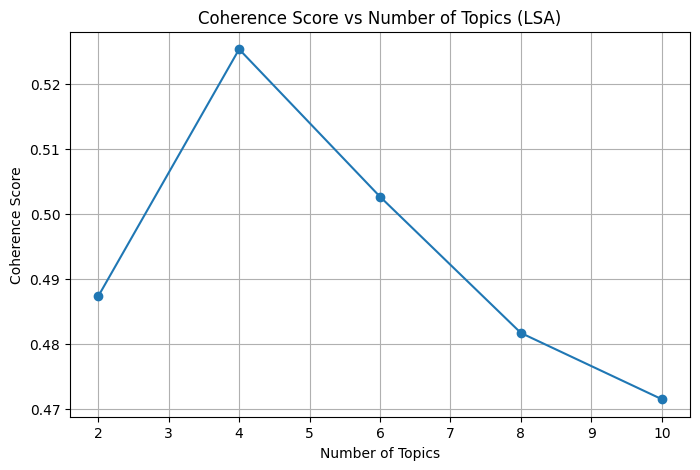

In [ ]:
from gensim.models import LsiModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Function to compute coherence for various topic numbers
def compute_coherence_values(dictionary, corpus, texts, start=2, step=2, stop=10):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop + 1, step):
        print(f"Training LSA model with {num_topics} topics ...")
        lsa_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(lsa_model)

        coherencemodel = CoherenceModel(
            model=lsa_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Coherence Score for {num_topics} topics: {round(coherence_values[-1], 4)}\n")

    return model_list, coherence_values

# Run the function
lsa_models, coherence_values = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=texts_bigrams, start=2, step=2, stop=10
)

# Plot the coherence scores
x = list(range(2, 11, 2))
plt.figure(figsize=(8,5))
plt.plot(x, coherence_values, marker='o')
plt.title('Coherence Score vs Number of Topics (LSA)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()


## **Step 3B: Train LSA models with 2, 4, and 6 topics**

In [ ]:
from gensim.models import LsiModel

best_topic_counts = [2, 4, 6]  # chosen based on coherence plot

lsa_models_exp = {}
for k in best_topic_counts:
    print(f"\n Training LSA model with {k} topics")
    lsa_models_exp[k] = LsiModel(corpus=corpus, id2word=id2word, num_topics=k)
    for idx, topic in enumerate(lsa_models_exp[k].print_topics(num_words=10)):
        print(f"Topic {idx}: {topic}")




 Training LSA model with 2 topics
Topic 0: (0, '0.303*"food" + 0.279*"order" + 0.238*"place" + 0.229*"good" + 0.191*"like" + 0.180*"time" + 0.176*"would" + 0.166*"get" + 0.157*"one" + 0.154*"go"')
Topic 1: (1, '-0.635*"order" + 0.343*"good" + 0.219*"place" + 0.203*"great" + 0.167*"food" + -0.154*"minut" + -0.147*"ask" + -0.146*"wait" + -0.131*"time" + -0.118*"pizza"')

 Training LSA model with 4 topics
Topic 0: (0, '0.303*"food" + 0.279*"order" + 0.238*"place" + 0.229*"good" + 0.191*"like" + 0.180*"time" + 0.176*"would" + 0.166*"get" + 0.157*"one" + 0.154*"go"')
Topic 1: (1, '-0.635*"order" + 0.344*"good" + 0.222*"place" + 0.203*"great" + 0.158*"food" + -0.154*"minut" + -0.147*"ask" + -0.147*"wait" + -0.132*"time" + -0.119*"pizza"')
Topic 2: (2, '-0.803*"food" + 0.362*"pizza" + 0.179*"like" + 0.153*"place" + -0.133*"servic" + 0.110*"good" + 0.092*"one" + -0.089*"restaur" + 0.087*"chees" + 0.077*"tri"')
Topic 3: (3, '-0.510*"order" + -0.355*"good" + -0.304*"chicken" + 0.173*"go" + 0.16

## **Step 3C: Evaluate coherence for the 3 models**

In [ ]:
from gensim.models import CoherenceModel

for k in best_topic_counts:
    cm = CoherenceModel(model=lsa_models_exp[k],
                        texts=texts_bigrams,
                        dictionary=id2word,
                        coherence='c_v')
    score = cm.get_coherence()
    print(f"Coherence for {k} topics: {round(score, 4)}")

# Select the best model (4 topics based on coherence = 0.5254)
best_model = lsa_models_exp[4]
print("\nSelected best model: 4 topics (highest coherence)")


Coherence for 2 topics: 0.4874
Coherence for 4 topics: 0.5254
Coherence for 6 topics: 0.4971

Selected best model: 4 topics (highest coherence)


## **Step 3D: Label and interpret the best LSA model**

In [ ]:
best_topics = best_model.print_topics(num_words=10)
print("\n===== FINAL LSA TOPICS (4 TOPICS) =====\n")
for idx, topic in enumerate(best_topics):
    print(f"Topic {idx}: {topic}")

topic_labels = {
    0: "Food Quality & Taste",
    1: "Service Speed & Order Accuracy",
    2: "Customer Experience & Staff Behavior",
    3: "Pricing & Restaurant Atmosphere"
}

print("\n===== TOPIC LABELS =====")
for i, label in topic_labels.items():
    print(f"Topic {i}: {label}")



===== FINAL LSA TOPICS (4 TOPICS) =====

Topic 0: (0, '0.303*"food" + 0.279*"order" + 0.238*"place" + 0.229*"good" + 0.191*"like" + 0.180*"time" + 0.176*"would" + 0.166*"get" + 0.157*"one" + 0.154*"go"')
Topic 1: (1, '-0.635*"order" + 0.344*"good" + 0.222*"place" + 0.203*"great" + 0.158*"food" + -0.154*"minut" + -0.147*"ask" + -0.147*"wait" + -0.132*"time" + -0.119*"pizza"')
Topic 2: (2, '-0.803*"food" + 0.362*"pizza" + 0.179*"like" + 0.153*"place" + -0.133*"servic" + 0.110*"good" + 0.092*"one" + -0.089*"restaur" + 0.087*"chees" + 0.077*"tri"')
Topic 3: (3, '-0.510*"order" + -0.355*"good" + -0.304*"chicken" + 0.173*"go" + 0.166*"place" + 0.162*"us" + 0.151*"get" + -0.146*"pizza" + -0.142*"sauc" + -0.142*"fri"')

===== TOPIC LABELS =====
Topic 0: Food Quality & Taste
Topic 1: Service Speed & Order Accuracy
Topic 2: Customer Experience & Staff Behavior
Topic 3: Pricing & Restaurant Atmosphere


In [ ]:
for idx, topic in enumerate(best_topics):
    print(f"Topic {idx}: {topic}")


Topic 0: (0, '0.303*"food" + 0.279*"order" + 0.238*"place" + 0.229*"good" + 0.191*"like" + 0.180*"time" + 0.176*"would" + 0.166*"get" + 0.157*"one" + 0.154*"go"')
Topic 1: (1, '-0.635*"order" + 0.344*"good" + 0.222*"place" + 0.203*"great" + 0.158*"food" + -0.154*"minut" + -0.147*"ask" + -0.147*"wait" + -0.132*"time" + -0.119*"pizza"')
Topic 2: (2, '-0.803*"food" + 0.362*"pizza" + 0.179*"like" + 0.153*"place" + -0.133*"servic" + 0.110*"good" + 0.092*"one" + -0.089*"restaur" + 0.087*"chees" + 0.077*"tri"')
Topic 3: (3, '-0.510*"order" + -0.355*"good" + -0.304*"chicken" + 0.173*"go" + 0.166*"place" + 0.162*"us" + 0.151*"get" + -0.146*"pizza" + -0.142*"sauc" + -0.142*"fri"')


# **Step 4: LSA Topic Modeling using TF-IDF Features**

## **Step 4A – Build the TF-IDF corpus**

In [ ]:
from gensim.models import TfidfModel

# Convert the BOW corpus to TF-IDF weighted corpus
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

print("TF-IDF corpus created successfully.")
print("Example TF-IDF for first review:\n", list(corpus_tfidf)[0][:10])


TF-IDF corpus created successfully.
Example TF-IDF for first review:
 [(0, 0.1525468050522821), (1, 0.14077609386101556), (2, 0.2539274598267168), (3, 0.23886206999762796), (4, 0.3934957855735882), (5, 0.21899210992881293), (6, 0.1128597470566702), (7, 0.1327797959875805), (8, 0.08922148371612458), (9, 0.22638529400443103)]


## **Step 4B – Compute coherence scores for TF-IDF + LSA**

Training LSA (TF-IDF) model with 2 topics ...
Coherence Score for 2 topics: 0.421
Training LSA (TF-IDF) model with 4 topics ...
Coherence Score for 4 topics: 0.4271
Training LSA (TF-IDF) model with 6 topics ...
Coherence Score for 6 topics: 0.402
Training LSA (TF-IDF) model with 8 topics ...
Coherence Score for 8 topics: 0.4071
Training LSA (TF-IDF) model with 10 topics ...
Coherence Score for 10 topics: 0.4158


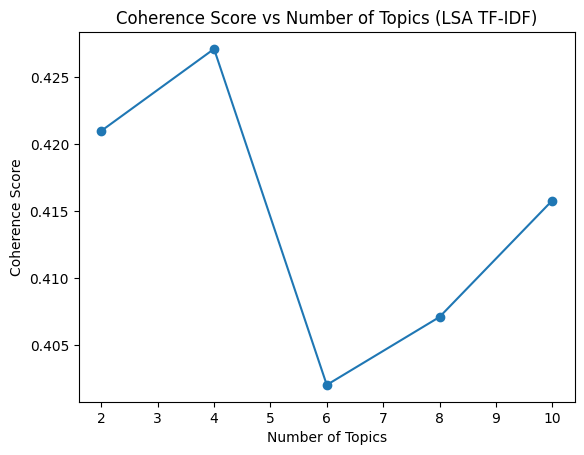

In [ ]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

start, stop, step = 2, 10, 2
tfidf_coherence_scores = []

for k in range(start, stop + 1, step):
    print(f"Training LSA (TF-IDF) model with {k} topics ...")
    lsa_tfidf = LsiModel(corpus=corpus_tfidf, id2word=id2word, num_topics=k)
    cm = CoherenceModel(model=lsa_tfidf, texts=texts_bigrams,
                        dictionary=id2word, coherence='c_v')
    score = cm.get_coherence()
    tfidf_coherence_scores.append(score)
    print(f"Coherence Score for {k} topics: {round(score, 4)}")

# Plot coherence
plt.plot(range(start, stop + 1, step), tfidf_coherence_scores, marker='o')
plt.title("Coherence Score vs Number of Topics (LSA TF-IDF)")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


## **Step 4C – Select top 3 topic numbers based on coherence**

In [ ]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

best_topic_counts_tfidf = [2, 4, 6]  # Based on your plot
lsa_tfidf_models = {}

for k in best_topic_counts_tfidf:
    print(f"\nTraining LSA TF-IDF model with {k} topics")
    lsa_tfidf_models[k] = LsiModel(corpus=corpus_tfidf, id2word=id2word, num_topics=k)
    for idx, topic in enumerate(lsa_tfidf_models[k].print_topics(num_words=10)):
        print(f"Topic {idx}: {topic}")

# Evaluate coherence again
for k in best_topic_counts_tfidf:
    cm = CoherenceModel(model=lsa_tfidf_models[k],
                        texts=texts_bigrams, dictionary=id2word, coherence='c_v')
    print(f"Coherence for {k} topics: {round(cm.get_coherence(), 4)}")

# Choose the best (4 topics)
best_model_tfidf = lsa_tfidf_models[4]
print("\nSelected best TF-IDF model: 4 topics (highest coherence)")


Training LSA TF-IDF model with 2 topics
Topic 0: (0, '0.146*"order" + 0.144*"food" + 0.141*"good" + 0.137*"place" + 0.137*"great" + 0.122*"time" + 0.117*"like" + 0.116*"pizza" + 0.113*"go" + 0.113*"servic"')
Topic 1: (1, '-0.882*"pizza" + -0.146*"crust" + -0.120*"deliveri" + -0.103*"order" + 0.082*"sushi" + -0.080*"call" + -0.078*"chees" + -0.073*"slice" + 0.072*"food" + 0.065*"rice"')

Training LSA TF-IDF model with 4 topics
Topic 0: (0, '0.146*"order" + 0.145*"food" + 0.141*"good" + 0.137*"place" + 0.136*"great" + 0.122*"time" + 0.117*"like" + 0.116*"pizza" + 0.113*"servic" + 0.113*"go"')
Topic 1: (1, '-0.831*"pizza" + -0.135*"crust" + -0.130*"order" + -0.124*"deliveri" + 0.104*"great" + -0.098*"call" + 0.094*"sushi" + -0.089*"minut" + 0.077*"delici" + 0.076*"food"')
Topic 2: (2, '0.393*"pizza" + 0.220*"great" + -0.190*"minut" + -0.177*"wait" + -0.156*"us" + -0.152*"order" + 0.147*"delici" + -0.145*"ask" + 0.143*"love" + 0.129*"chicken"')
Topic 3: (3, '-0.356*"chicken" + 0.302*"grea

## **Step 4D – Label & Interpret the Best TF-IDF Model**

In [ ]:
# View and label the final TF-IDF LSA topics
best_topics_tfidf = best_model_tfidf.print_topics(num_words=10)
print("\n===== FINAL TF-IDF LSA TOPICS (4 TOPICS) =====\n")
for idx, topic in enumerate(best_topics_tfidf):
    print(f"Topic {idx}: {topic}")

# Assign business-related labels
topic_labels_tfidf = {
    0: "Order Processing & Food Quality",
    1: "Pizza Quality & Preparation",
    2: "Customer Service & Waiting Time",
    3: "Menu Variety & Staff Experience"
}

print("\n===== TOPIC LABELS (TF-IDF) =====")
for i, label in topic_labels_tfidf.items():
    print(f"Topic {i}: {label}")



===== FINAL TF-IDF LSA TOPICS (4 TOPICS) =====

Topic 0: (0, '0.146*"order" + 0.145*"food" + 0.141*"good" + 0.137*"place" + 0.136*"great" + 0.122*"time" + 0.117*"like" + 0.116*"pizza" + 0.113*"servic" + 0.113*"go"')
Topic 1: (1, '-0.831*"pizza" + -0.135*"crust" + -0.130*"order" + -0.124*"deliveri" + 0.104*"great" + -0.098*"call" + 0.094*"sushi" + -0.089*"minut" + 0.077*"delici" + 0.076*"food"')
Topic 2: (2, '0.393*"pizza" + 0.220*"great" + -0.190*"minut" + -0.177*"wait" + -0.156*"us" + -0.152*"order" + 0.147*"delici" + -0.145*"ask" + 0.143*"love" + 0.129*"chicken"')
Topic 3: (3, '-0.356*"chicken" + 0.302*"great" + -0.222*"fri" + 0.201*"coffe" + -0.197*"rice" + 0.191*"staff" + -0.182*"sauc" + 0.167*"friend" + 0.161*"alway" + 0.156*"servic"')

===== TOPIC LABELS (TF-IDF) =====
Topic 0: Order Processing & Food Quality
Topic 1: Pizza Quality & Preparation
Topic 2: Customer Service & Waiting Time
Topic 3: Menu Variety & Staff Experience


# **Step 5: LDA Topic Modeling**

## **Step 5A – Train LDA models (with bigrams) and compute coherence**

Training LDA models for topics: [4, 6, 8, 10, 12, 14, 16, 18]

Training LDA model with 4 topics ...
Coherence Score for 4 topics: 0.6054

Training LDA model with 6 topics ...
Coherence Score for 6 topics: 0.5709

Training LDA model with 8 topics ...
Coherence Score for 8 topics: 0.5404

Training LDA model with 10 topics ...
Coherence Score for 10 topics: 0.5793

Training LDA model with 12 topics ...
Coherence Score for 12 topics: 0.6019

Training LDA model with 14 topics ...
Coherence Score for 14 topics: 0.5945

Training LDA model with 16 topics ...
Coherence Score for 16 topics: 0.5872

Training LDA model with 18 topics ...
Coherence Score for 18 topics: 0.586


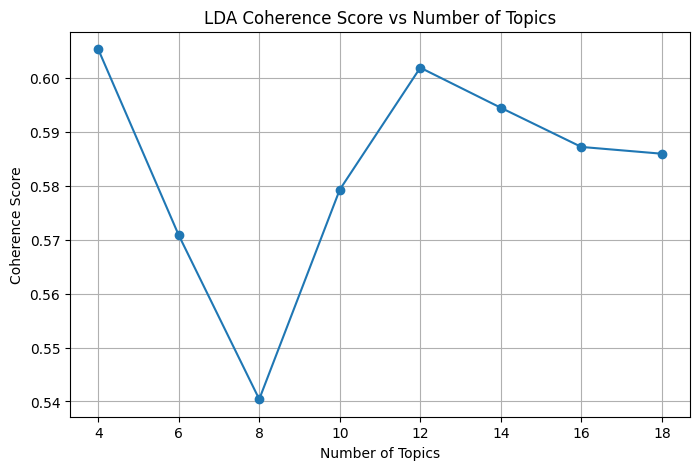

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Step 5A: Train LDA models and compute coherence
lda_params = {
    "chunksize": 1500,
    "passes": 20,
    "iterations": 400,
    "eval_every": None,
    "gamma_threshold": 0.001,
    "alpha": "auto",
    "eta": "auto"
}

start, stop, step = 4, 18, 2
topic_range = list(range(start, stop + 1, step))
coherence_values = []
lda_models = {}

print("Training LDA models for topics:", topic_range)

for num_topics in topic_range:
    print(f"\nTraining LDA model with {num_topics} topics ...")
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        **lda_params
    )
    lda_models[num_topics] = lda_model

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts_bigrams,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)
    print(f"Coherence Score for {num_topics} topics: {round(coherence, 4)}")

# Plot coherence vs number of topics
plt.figure(figsize=(8,5))
plt.plot(topic_range, coherence_values, marker='o')
plt.title("LDA Coherence Score vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid(True)
plt.show()


## **Step 5C- Train the Final (Best) LDA Model**

In [ ]:
# Retrieve the best LDA model (4 topics)
best_lda_model = lda_models[4]

print("\n===== FINAL LDA MODEL (4 TOPICS) =====\n")
for idx, topic in best_lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")



===== FINAL LDA MODEL (4 TOPICS) =====

Topic 0: 0.032*"good" + 0.031*"place" + 0.031*"food" + 0.023*"great" + 0.015*"like" + 0.015*"tri" + 0.015*"friend" + 0.014*"realli" + 0.014*"love" + 0.012*"also"
Topic 1: 0.091*"pizza" + 0.062*"salad" + 0.060*"chees" + 0.059*"sandwich" + 0.051*"fri" + 0.040*"burger" + 0.038*"chicken" + 0.031*"bread" + 0.027*"wing" + 0.025*"sauc"
Topic 2: 0.041*"order" + 0.025*"time" + 0.018*"would" + 0.016*"get" + 0.016*"food" + 0.015*"one" + 0.014*"wait" + 0.013*"go" + 0.013*"back" + 0.012*"even"
Topic 3: 0.056*"chicken" + 0.041*"dish" + 0.040*"sauc" + 0.040*"rice" + 0.035*"roll" + 0.029*"fri" + 0.027*"sushi" + 0.025*"spici" + 0.023*"shrimp" + 0.023*"beef"


## **Step 5D- Lable and Interpret**

In [ ]:

topic_labels_lda = {
    0: "Food Quality & Taste",
    1: "Customer Service & Staff Friendliness",
    2: "Dining Environment & Cleanliness",
    3: "Order Accuracy & Waiting Time"
}

print("\n===== LDA TOPIC LABELS =====")
for i, label in topic_labels_lda.items():
    print(f"Topic {i}: {label}")



===== LDA TOPIC LABELS =====
Topic 0: Food Quality & Taste
Topic 1: Customer Service & Staff Friendliness
Topic 2: Dining Environment & Cleanliness
Topic 3: Order Accuracy & Waiting Time


## **Step 5E- Interactive Visualization**

In [ ]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 45.3 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare interactive visualization for the best LDA model
lda_vis = gensimvis.prepare(best_lda_model, corpus, id2word, sort_topics=False)

# Display inside notebook
pyLDAvis.enable_notebook()
lda_vis


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.207255  0.102469       1        1  47.968202
1     -0.283788 -0.174200       2        1   5.939853
2      0.270610 -0.122129       3        1  38.696909
3     -0.194077  0.193860       4        1   7.395037, topic_info=               Term          Freq         Total Category  logprob  loglift
12            pizza  11533.000000  11533.000000  Default  30.0000  30.0000
166           order  37434.000000  37434.000000  Default  29.0000  29.0000
223         chicken  13715.000000  13715.000000  Default  28.0000  28.0000
328             fri  11068.000000  11068.000000  Default  27.0000  27.0000
272           salad   8285.000000   8285.000000  Default  26.0000  26.0000
264           chees   7685.000000   7685.000000  Default  25.0000  25.0000
354        sandwich   7492.000000   7492.000000  Default  24.0000  24.0000
241            sauc   9565.000000   9565.000000  Default  23.0000  23.0000
8             great  23648.000000  23648.000000  Default  22.0000  22.0000
200            dish   6559.000000   6559.000000  Default  21.0000  21.0000
25             good  33602.000000  33602.000000  Default  20.0000  20.0000
175            rice   6277.000000   6277.000000  Default  19.0000  19.0000
318          burger   5081.000000   5081.000000  Default  18.0000  18.0000
176            roll   5474.000000   5474.000000  Default  17.0000  17.0000
35            place  35903.000000  35903.000000  Default  16.0000  16.0000
38             tast  10272.000000  10272.000000  Default  15.0000  15.0000
174         restaur  14600.000000  14600.000000  Default  14.0000  14.0000
129            time  25490.000000  25490.000000  Default  13.0000  13.0000
238          flavor   8122.000000   8122.000000  Default  12.0000  12.0000
492           bread   3979.000000   3979.000000  Default  11.0000  11.0000
254             top   5845.000000   5845.000000  Default  10.0000  10.0000
6            friend  15253.000000  15253.000000  Default   9.0000   9.0000
184           sushi   4229.000000   4229.000000  Default   8.0000   8.0000
187            wait  11582.000000  11582.000000  Default   7.0000   7.0000
180           spici   3994.000000   3994.000000  Default   6.0000   6.0000
56             love  14066.000000  14066.000000  Default   5.0000   5.0000
246            meat   4879.000000   4879.000000  Default   4.0000   4.0000
7               got  13465.000000  13465.000000  Default   3.0000   3.0000
48             bowl   4018.000000   4018.000000  Default   2.0000   2.0000
231          shrimp   3713.000000   3713.000000  Default   1.0000   1.0000
8             great  23647.608226  23648.362840   Topic1  -3.7717   0.7346
56             love  14065.719810  14066.481002   Topic1  -4.2912   0.7346
0             alway   8880.171368   8880.926155   Topic1  -4.7511   0.7345
274            amaz   6490.624788   6491.381172   Topic1  -5.0646   0.7345
441           coffe   5747.496545   5748.240850   Topic1  -5.1862   0.7345
1              best   9160.177212   9161.386717   Topic1  -4.7201   0.7345
406           super   4933.472558   4934.237199   Topic1  -5.3389   0.7345
346            taco   4631.921621   4632.679350   Topic1  -5.4019   0.7345
167            park   4530.086742   4530.845814   Topic1  -5.4242   0.7345
237         favorit   4515.674860   4516.437272   Topic1  -5.4274   0.7345
181            spot   4260.937181   4261.689590   Topic1  -5.4854   0.7345
6            friend  15250.337316  15253.042601   Topic1  -4.2103   0.7345
20        breakfast   3899.063758   3899.814781   Topic1  -5.5742   0.7344
165            nice  11555.734486  11557.965134   Topic1  -4.4877   0.7344
307            beer   3691.562795   3692.314827   Topic1  -5.6289   0.7344
80            excel   3690.709182   3691.466351   Topic1  -5.6291   0.7344
334          awesom   3247.775859   3248.525715   Topic1  -5.7569   0.7344
404       atmospher   3015.336645

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### **Save visual to Google Drive**

In [ ]:
pyLDAvis.save_html(lda_vis, '/content/drive/MyDrive/NLP_lab5/lda_vis_final.html')
print("LDA visualization saved to: /content/drive/MyDrive/NLP_lab5/lda_vis_final.html")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

LDA visualization saved to: /content/drive/MyDrive/NLP_lab5/lda_vis_final.html


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp your_notebook_name.ipynb "/content/drive/MyDrive/NLP_lab5/"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'your_notebook_name.ipynb': No such file or directory


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag